## STA 160

## Final Project: 

In [41]:
# Import Libraries
import pandas as pd
import numpy as np

import requests
import json
import datetime as dt
import itertools
from itertools import repeat

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [14]:
%run ../code/weather_scraper.py
el_dorado_df = weather_to_df(fips_code="06017",county = "El Dorado")
imperial_df = weather_to_df(fips_code="06025",county = "Imperial")
mendocino_df = weather_to_df(fips_code="06045",county = "Mendocino")
riverside_df = weather_to_df(fips_code="06065",county = "Riverside")
siskiyou_df = weather_to_df(fips_code="06093",county = "Siskiyou")
solano_df = weather_to_df(fips_code="06095",county = "Solano")

## Our Data:

Weather Data:
- stored in object: df_weather
- Rows: 15 minute interval in a given day. (96 rows per day)
- Columns: Date,tmax(temp),tmin(temp),Precip,average(temp),daily_avg_windspeed, county
- Instances:
    - dataL: Solano, FIPS = 095
    - dataS: Siskiyou, FIPS = 093
    - dataR: Riverside, FIPS = 065
    - dataM: Mendocino, FIPS = 045
    - dataI: Imperial, FIPS = 025
    - dataE: El Dorado, FIPS = 017
    
Fire Data:
- stored in object: fire_data
- Rows: a unique wildfire
- Columns: FPA_ID, FIRE_CODE, FIRE_NAME, FIRE_YEAR, date(DISCOVERY_DATE), DISCOVERY_TIME, STAT_CAUSE_CODE, STAT_CAUSE_DESCR, date(CONT_DATE), FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, FIPS_CODE,FIPS_NAME,STATE.

## Next Step:

- Segment fire data by fire_class. 
    - Note: fire_classes are imbalanced. We randomly subset 15 observations within larger fire classes. (15 samples in the smallest fire class.)
- Investigate weather conditions of discovery date +- 7 days of each instance per fire_class. 
    - Hierarchical clustering of avg_temp, precip, avg_windspeed of all 5*45 observations for each day within the 14 day range. 
        - i.e. See if fires of the same fire class have similar structures for t-72 hours before discovery
        - Maybe identify fires that are started by arson.
        - 
- K-means clustering of geospatial data for 2 week intervals to identify trends in fire location.   


In [59]:
# scrape merced data
dataL = pd.DataFrame()
new = []

date = ["03", "06", "07", "10"]

for d in date:
    start = "01-01-20" +d
    end = "12-31-20" +d
    dates = pd.date_range(start=start, end=end, freq = 'Y')
    dates = dates.strftime("%Y")   
    dates = dates.to_list()        
    
    Token = 'eLCmbnPGUBzvYdVYFMZYpulbSoXjYkfX'

    date_rain = []
    date_tmax = []
    date_tmin = []
    rain_lst = []
    tmin_lst = []
    tmax_lst = []

    #query API for data of interest:
    for i in dates: #loop through list of years and append them to API call where appropriate
        temp_max = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&limit=1000&locationid=FIPS:06047&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})
        rain = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=PRCP&limit=1000&locationid=FIPS:06047&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})
        temp_min = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMIN&limit=1000&locationid=FIPS:06047&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})

        #convert to JSON:
        rain = rain.json()
        tmin = temp_min.json()
        tmax = temp_max.json()

        #create dataframe for each API call:
        rain_table = pd.json_normalize(rain["results"])
        tmin_table = pd.json_normalize(tmin["results"])
        tmax_table = pd.json_normalize(tmax["results"])

        #append data to appropriate list in order to construct overall dataset for Solano:
        date_rain.append(rain_table["date"].tolist())
        rain_lst.append(rain_table["value"].tolist())
        date_tmin.append(tmin_table['date'].tolist())
        tmin_lst.append(tmin_table['value'].tolist())
        date_tmax.append(tmax_table['date'].tolist())
        tmax_lst.append(tmax_table['value'].tolist())

    #create dataset with date and value for each paramter of interest:
    rain_data = pd.DataFrame({
        "Date":list(itertools.chain.from_iterable(date_rain)),
        "Precip":list(itertools.chain.from_iterable(rain_lst))})

    tmax_data = pd.DataFrame({
        "Date":list(itertools.chain.from_iterable(date_tmax)),
        "tmax":list(itertools.chain.from_iterable(tmax_lst))})

    tmin_data = pd.DataFrame({
        "Date": list(itertools.chain.from_iterable(date_tmin)),
        "tmin":list(itertools.chain.from_iterable(tmin_lst))})
    
    #set indices:
    rain_data = rain_data.set_index("Date")
    tmax_data = tmax_data.set_index("Date")
    tmin_data = tmin_data.set_index("Date")
    
    #clean dates and set indices for merge:

    #clean date variable:
    rain_data.index = pd.to_datetime(rain_data.index)
    tmax_data.index = pd.to_datetime(tmax_data.index)
    tmin_data.index = pd.to_datetime(tmin_data.index)

    #merge datasets into 1 dataset:
    merced_dat = tmax_data.merge(tmin_data, how = "left",left_index=True, right_index=True)
    merced_dat = merced_dat.merge(rain_data, how = "inner",left_index=True, right_index=True)
    merced_dat["average"] = merced_dat["tmin"]+((merced_dat["tmax"]-merced_dat["tmin"])/2) #compute average temperature
    merced_dat = merced_dat.dropna()
    
    #append into one dataframe
    new.append(merced_dat)

#show dataset:
dataZ = pd.concat(new)
print(dataZ)
dataZ.to_csv('dataZ.csv')

            tmax  tmin  Precip  average
Date                                   
2003-01-01  57.0  34.0    0.00     45.5
2003-01-01  57.0  34.0    0.02     45.5
2003-01-01  57.0  34.0    0.00     45.5
2003-01-01  57.0  34.0    0.03     45.5
2003-01-01  57.0  34.0    0.00     45.5
...          ...   ...     ...      ...
2010-05-25  75.0  43.0    0.01     59.0
2010-05-25  75.0  43.0    0.00     59.0
2010-05-25  75.0  43.0    0.00     59.0
2010-05-25  75.0  43.0    0.13     59.0
2010-05-25  75.0  43.0    0.12     59.0

[234812 rows x 4 columns]


## The next 3 chunks are troublesome @Cindy because all_weather only has ~2000 rows

In [84]:
# import temp and precipitation data:

dataE = pd.read_csv('../data/dataE.csv') # El Dorado
dataE['FIPS_NAME'] = 'El Dorado'

dataI = pd.read_csv('../data/dataI.csv') # Imperial
dataI['FIPS_NAME'] = 'Imperial'

dataZ = pd.read_csv('../data/dataZ.csv') # Merced
dataZ['FIPS_NAME'] = 'Merced'

dataM = pd.read_csv('../data/dataM.csv') # Mendocino
dataM['FIPS_NAME'] = 'Mendocino'

dataR = pd.read_csv('../data/dataR.csv') # Riverside
dataR['FIPS_NAME'] = 'Riverside'

dataS = pd.read_csv('../data/dataS.csv') # Siskyou
dataS['FIPS_NAME'] = 'Siskyou'

all_temp_precip = pd.concat([dataE,dataI,dataZ,dataM,dataR,dataS])
all_temp_precip['Date'] = pd.to_datetime(all_temp_precip['Date'])
all_temp_precip = all_temp_precip.drop_duplicates(subset=['Date','FIPS_NAME'],keep='first')
all_temp_precip

,Date,tmax,tmin,Precip,average,FIPS_NAME
0,2003-01-01,50.0,42.0,0.00,46.0,El Dorado
1000,2003-01-02,44.0,29.0,0.00,36.5,El Dorado
2584,2003-01-03,53.0,31.0,0.00,42.0,El Dorado
4168,2003-01-04,64.0,42.0,0.00,53.0,El Dorado
5499,2003-01-05,69.0,44.0,0.00,56.5,El Dorado
...,...,...,...,...,...,...
1277789,2010-02-05,50.0,30.0,0.19,40.0,Siskyou
1289453,2010-02-06,51.0,38.0,0.01,44.5,Siskyou
1297517,2010-02-07,50.0,35.0,0.01,42.5,Siskyou
1305581,2010-02-08,48.0,27.0,0.00,37.5,Siskyou


In [79]:
# import wind data:
imperial_wind = pd.read_csv('../data/Imperial_county_wind_data.csv')
imperial_wind['FIPS_NAME'] = 'Imperial'

merced_wind = pd.read_csv('../data/Merced_county_wind_data.csv')
merced_wind['FIPS_NAME'] = 'Merced'

mendocino_wind = pd.read_csv('../data/Mendocino_county_wind_data.csv')
mendocino_wind['FIPS_NAME'] = 'Mendocino'

riverside_wind = pd.read_csv('../data/Riverside_county_wind_data.csv')
riverside_wind['FIPS_NAME'] = 'Riverside'

siskyou_wind = pd.read_csv('../data/Siskyou_county_wind_data.csv')
siskyou_wind['FIPS_NAME'] = 'Siskyou'

eldorado_wind = pd.read_csv('../data/el_dorado_county_wind_data.csv')
eldorado_wind['FIPS_NAME'] = 'El Dorado'

all_wind = pd.concat([imperial_wind,merced_wind,riverside_wind,siskyou_wind,eldorado_wind])
all_wind['Date'] = pd.to_datetime(all_wind['Date'])
all_wind1 = all_wind[all_wind['Date'] < '2010-05-26']
all_wind1

,Date,wind_speed,FIPS_NAME
0,2003-01-01,5.6,Imperial
1,2003-01-02,5.6,Imperial
2,2003-01-03,3.8,Imperial
3,2003-01-03,3.1,Imperial
4,2003-01-04,3.1,Imperial
...,...,...,...
1235,2010-05-21,12.5,El Dorado
1236,2010-05-22,6.0,El Dorado
1237,2010-05-23,4.3,El Dorado
1238,2010-05-24,8.1,El Dorado


In [81]:
# join wind, temp, precipitation data
all_weather = pd.merge(all_wind,all_temp_precip,how='inner',on=['Date','FIPS_NAME'])
all_weather

,Date,wind_speed,FIPS_NAME,tmax,tmin,Precip,average
0,2003-01-01,5.6,Imperial,70.0,37.0,0.00,53.5
1,2003-01-02,5.6,Imperial,72.0,37.0,0.00,54.5
2,2003-01-03,3.8,Imperial,74.0,38.0,0.00,56.0
3,2003-01-03,3.1,Imperial,74.0,38.0,0.00,56.0
4,2003-01-04,3.1,Imperial,75.0,39.0,0.00,57.0
...,...,...,...,...,...,...,...
2029,2010-02-28,2.5,El Dorado,57.0,39.0,0.06,48.0
2030,2010-03-01,4.0,El Dorado,58.0,40.0,0.00,49.0
2031,2010-03-02,6.3,El Dorado,44.0,40.0,0.00,42.0
2032,2010-03-03,5.8,El Dorado,44.0,37.0,0.35,40.5


In [48]:
# identify dates for each day within discovery_date +-7
minus_7,minus_6,minus_5,minus_4,minus_3,minus_2,minus_1,day_of,plus_1,plus_2,plus_3,plus_4,plus_5,plus_6,plus_7 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
for date in all_com_1['Date']:
    minus_7.append(date - dt.timedelta(days=7))
    minus_6.append(date - dt.timedelta(days=6))
    minus_5.append(date - dt.timedelta(days=5))
    minus_4.append(date - dt.timedelta(days=4))
    minus_3.append(date - dt.timedelta(days=3))
    minus_2.append(date - dt.timedelta(days=2))
    minus_1.append(date - dt.timedelta(days=1))
    day_of.append(date)
    plus_1.append(date + dt.timedelta(days=1))
    plus_2.append(date + dt.timedelta(days=2))
    plus_3.append(date + dt.timedelta(days=3))
    plus_4.append(date + dt.timedelta(days=4))
    plus_5.append(date + dt.timedelta(days=5))
    plus_6.append(date + dt.timedelta(days=6))
    plus_7.append(date + dt.timedelta(days=7))

# subset weather data for each day 


In [8]:
dendro_subset = all_com_wind_2[['wind_speed','Precip','average']]
dendro_subset

,wind_speed,Precip,average
0,2.7,0.0,39.0
5,2.7,0.1,39.0
11,2.7,0.0,43.5
16,2.7,0.1,43.5
22,2.7,0.0,46.0
...,...,...,...
816269,3.6,0.0,66.0
816276,3.6,0.0,69.0
816283,3.6,0.0,70.0
816290,3.6,0.0,66.5


In [9]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

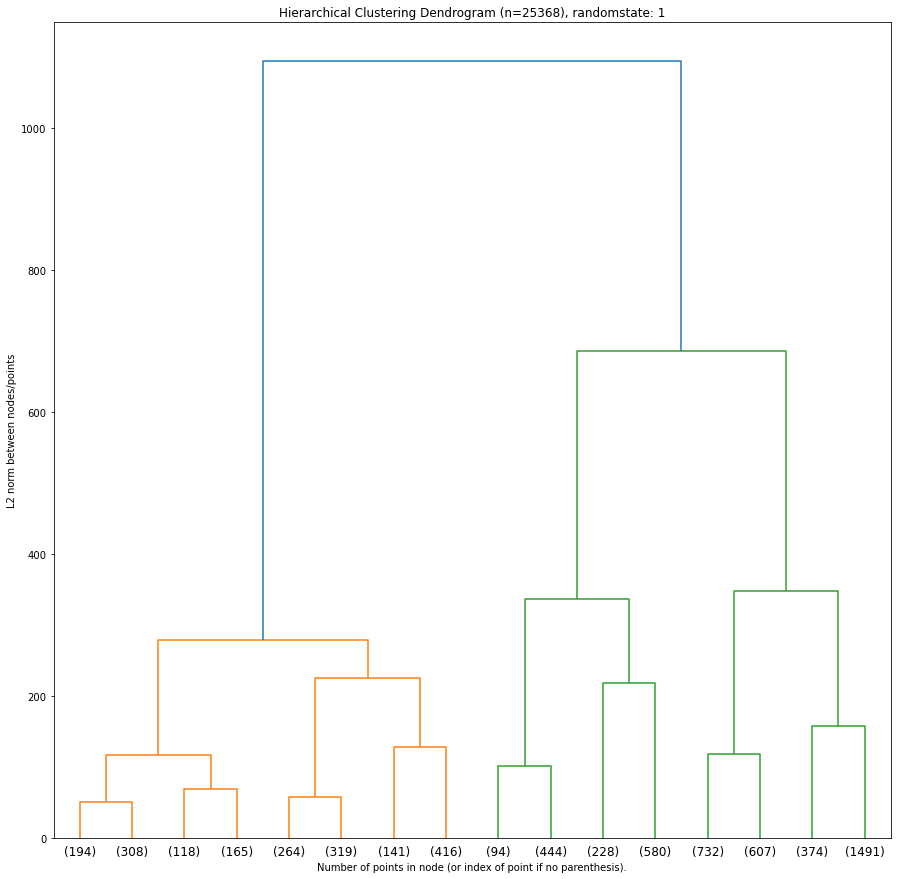

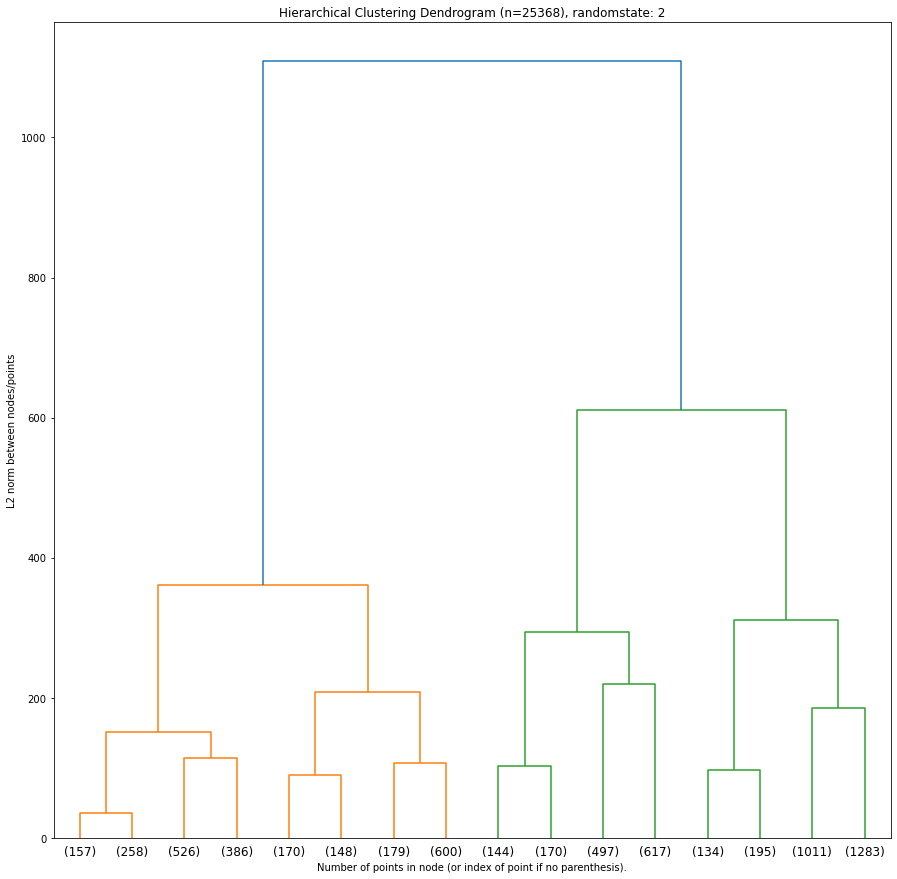

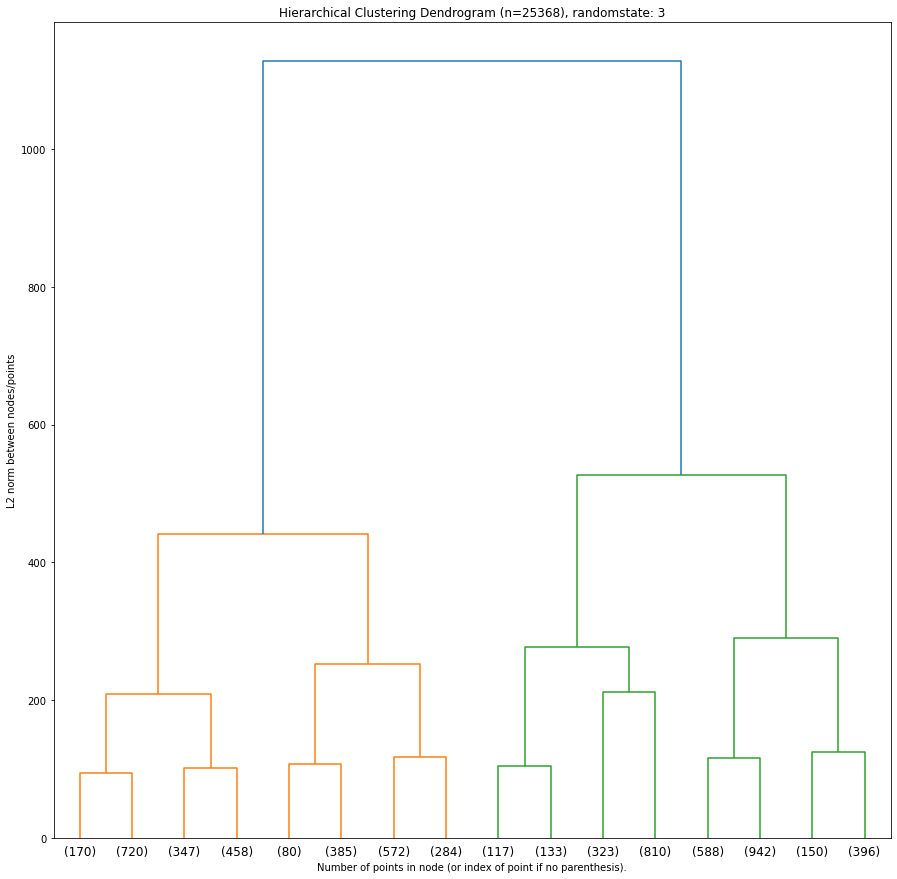

<Figure size 1080x1080 with 0 Axes>

In [11]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold

dendro_array = dendro_subset.to_numpy()

fold = 0
kf = KFold(n_splits = 10, random_state = True, shuffle = True)
plt.rcParams["figure.figsize"] = (15,15)
for train_index, test_index in kf.split(dendro_array):
    fold+=1
    temp_X = dendro_array[test_index] 
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(temp_X)
    plt.title("Hierarchical Clustering Dendrogram (n=25368), randomstate: %d" %fold)
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.ylabel("L2 norm between nodes/points")
    plt.show()
    plt.savefig('dendro.png')
    if fold ==3:
        break

## Clustering on Location
# True labels are FIRE_SIZE_CLASS
# Predicted labels using k-means